In [5]:
import pandas as pd
import numpy as np
import scipy

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
import optuna

import pickle

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import gc

In [6]:
with open("./inter_files/addon_features.pickle", 'rb') as f:
    addon_features = pickle.load(f)
    
addon_features

['searchid', 'adid', 'locationid']

In [7]:
%%time
sample = pd.read_parquet('./data/preprocessed_data.parquet')
sample = sample[list(set(sample.columns) - set(addon_features))]
print(sample.shape)
display(sample.head())

(4847835, 12)


,histctr,iscontext,title,params,price,position,parentcategoryid,categoryid,subcategoryid,target,level,objecttype
0,0.005468,1,Комбинезон COCOON,Комбинезоны и боди,711.0,1,3.0,60.0,43.0,0,3.0,3
1,0.000010,1,Кеды,Обувь,1699.0,7,3.0,60.0,43.0,0,3.0,3
2,0.005610,1,Виброрейка MASALTA MCD-4,Инструменты,54503.0,1,9.0,50.0,23.0,0,3.0,3
3,0.001788,1,Куртка утепленная Savage с доставкой,Верхняя одежда,3998.0,1,3.0,22.0,47.0,0,3.0,3
4,0.001435,1,Внешний аккумулятор для iPhone 2600 mAh,iPhone,399.0,7,12.0,41.0,42.0,0,3.0,3


CPU times: total: 3.06 s
Wall time: 1.41 s


In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847835 entries, 0 to 4847834
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   histctr           float64
 1   iscontext         int64  
 2   title             object 
 3   params            object 
 4   price             float64
 5   position          int64  
 6   parentcategoryid  float64
 7   categoryid        float64
 8   subcategoryid     float64
 9   target            int32  
 10  level             float64
 11  objecttype        int64  
dtypes: float64(6), int32(1), int64(3), object(2)
memory usage: 425.3+ MB


target
0    0.99395
1    0.00605
Name: count, dtype: float64


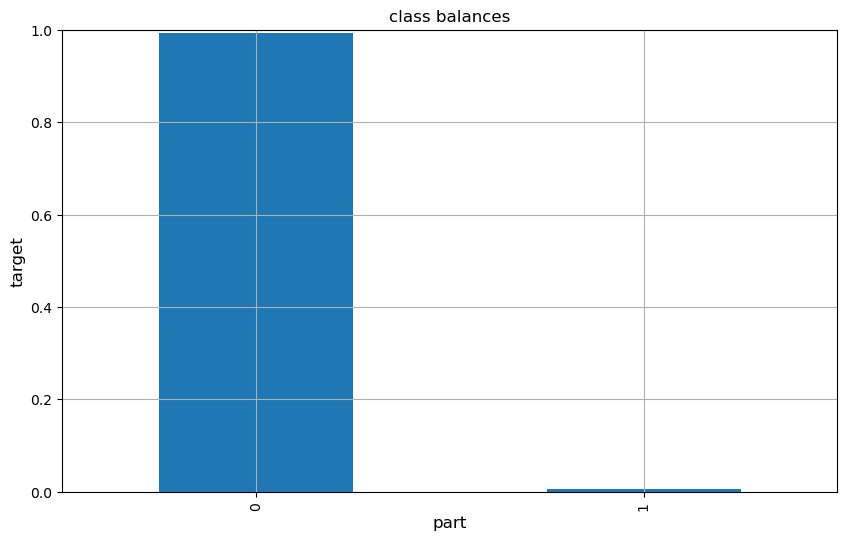

In [9]:
print((sample['target'].value_counts() / len(sample)))
plt.figure(figsize = (10, 6))

(sample['target'].value_counts() / len(sample)).plot(kind='bar')
plt.ylabel('target', fontsize = 12)
plt.xlabel('part', fontsize = 12)
plt.title('class balances')
plt.ylim(0, 1)
plt.grid(True)

plt.show()

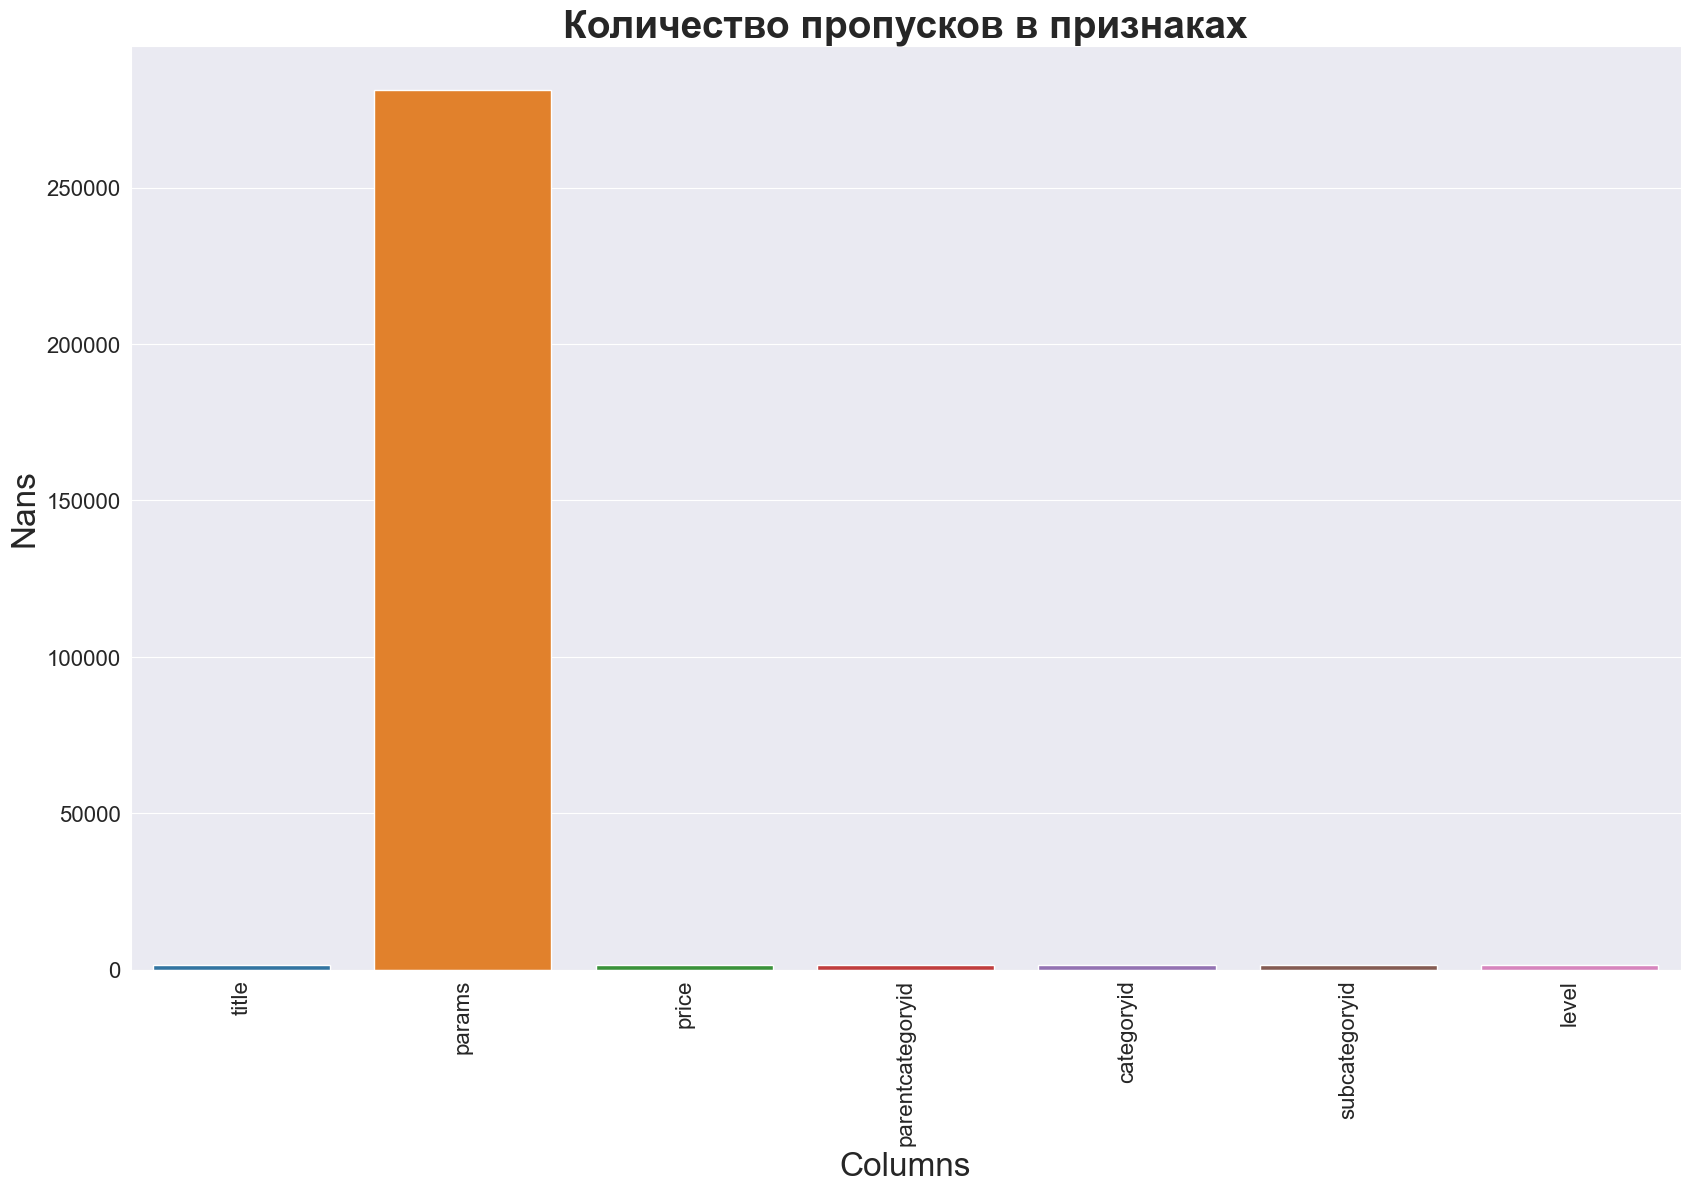

In [10]:
nan_columns_names = []
nan_columns_total = []

for column in sample.columns:
    if (sample[column].isnull().sum() > 0):
        nan_columns_names.append(column)
        nan_columns_total.append(sample[column].isnull().sum())

sns.set_style('darkgrid')
plt.figure(figsize = (20, 12))
sns.barplot(x = nan_columns_names, y = nan_columns_total)
plt.xticks(rotation = 90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Columns', fontsize = 24)
plt.ylabel('Nans', fontsize = 24)
plt.title('Количество пропусков в признаках', fontsize = 28, fontweight = 'bold')
plt.show()

In [11]:
sample[['params', 'title']] = sample[['params', 'title']].fillna('None')
sample[['price', 'parentcategoryid', 'categoryid', 'subcategoryid', 'level']] = sample[['price', 'parentcategoryid', 'categoryid', 'subcategoryid', 'level']].fillna(0)

In [12]:
X = sample[list(set(sample.columns) - set(addon_features + ['target']))].copy()
Y = sample['target'].copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.6, test_size = 0.4, random_state = 111)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size = 0.5, random_state = 111)

print('all: ', len(sample))
print('train: ', len(X_train))
print('valid: ', len(X_valid))
print('test: ', len(X_test))

all:  4847835
train:  2908701
valid:  969567
test:  969567


# Обучение модели

In [14]:
def metric_num_features_dependence(clf, X_train, y_train, X_valid, y_valid, X_test, y_test, df_features_imp, to_csv = True):
    feat_select = pd.DataFrame()
    
    for num_feat in tqdm(range(1, len(df_features_imp) + 1)):
        cur_features = df_features_imp['feature_name'].values[:num_feat]
        
        clf.fit(X_train, y_train, eval_set = (X_valid, y_valid), verbose=False)
        
        r = pd.Series()
        r.name = num_feat
        r['Train'] = 2*roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])-1
        r['Valid'] = 2*roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])-1
        r['Test'] = 2*roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])-1
        
        feat_select = pd.concat([feat_select, pd.DataFrame([r])], ignore_index=True)
    
    if to_csv:
        feat_select.to_csv('./inter_files/num_features_metrics.csv', index=False)
    
    plt.figure(figsize=(10, 5))
    
    plt.plot(feat_select['Train'], label='train')
    plt.plot(feat_select['Valid'], label='valid')
    plt.plot(feat_select['Test'], label='test')
    plt.xlabel('Num features')
    plt.ylabel('Gini')
    plt.grid()
    plt.legend()
    
    plt.show()
    
    return feat_select

In [15]:
cat_features = ['title', 'params']

In [16]:
clf_base = CatBoostClassifier(task_type='GPU',
                              cat_features = cat_features,
                              learning_rate=0.1,
                              depth = 4,
                              gpu_ram_part=0.9,
                              random_seed=98723,
                              loss_function='Logloss',
                              iterations=10_000,
                              use_best_model=True,
                              eval_metric='AUC',
                              verbose=False,
                              thread_count=-1,
                              min_data_in_leaf=200,
                              early_stopping_rounds=200)

clf_base.fit(X_train, y_train, eval_set = (X_valid, y_valid), verbose=100)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6548553	best: 0.6548553 (0)	total: 86.3ms	remaining: 14m 23s
100:	test: 0.7242112	best: 0.7242112 (100)	total: 8.48s	remaining: 13m 51s
200:	test: 0.7275071	best: 0.7275159 (199)	total: 17.1s	remaining: 13m 52s
300:	test: 0.7292252	best: 0.7292252 (300)	total: 25.8s	remaining: 13m 51s
400:	test: 0.7301832	best: 0.7302192 (398)	total: 35s	remaining: 13m 56s
500:	test: 0.7306615	best: 0.7306615 (500)	total: 43.9s	remaining: 13m 52s
600:	test: 0.7310988	best: 0.7311048 (598)	total: 52.6s	remaining: 13m 43s
700:	test: 0.7312346	best: 0.7313253 (656)	total: 1m	remaining: 13m 25s
800:	test: 0.7314157	best: 0.7314450 (786)	total: 1m 9s	remaining: 13m 14s
900:	test: 0.7316027	best: 0.7316450 (889)	total: 1m 18s	remaining: 13m 11s
1000:	test: 0.7317577	best: 0.7317794 (981)	total: 1m 27s	remaining: 13m 4s
1100:	test: 0.7317666	best: 0.7318294 (1044)	total: 1m 36s	remaining: 12m 59s
1200:	test: 0.7318915	best: 0.7318958 (1198)	total: 1m 44s	remaining: 12m 44s
1300:	test: 0.7318915	bes

In [17]:
gini_train_base_all_features = 2*roc_auc_score(y_train, clf_base.predict_proba(X_train)[:, 1])-1
gini_valid_base_all_features = 2*roc_auc_score(y_valid, clf_base.predict_proba(X_valid)[:, 1])-1
gini_test_base_all_features = 2*roc_auc_score(y_test, clf_base.predict_proba(X_test)[:, 1])-1

print('gini_train base_model_all_features: ', gini_train_base_all_features)
print('gini_valid base_model_all_features: ', gini_valid_base_all_features)
print('gini_test base_model_all_features: ', gini_test_base_all_features)

print()

print("Относительное изменение Gini base_model_all_features:")
print((gini_train_base_all_features - gini_test_base_all_features)*100 / gini_train_base_all_features)

gini_train base_model_all_features:  0.500094493309013
gini_valid base_model_all_features:  0.46421468575500535
gini_test base_model_all_features:  0.46195147704774353

Относительное изменение Gini base_model_all_features:
7.627161820736258


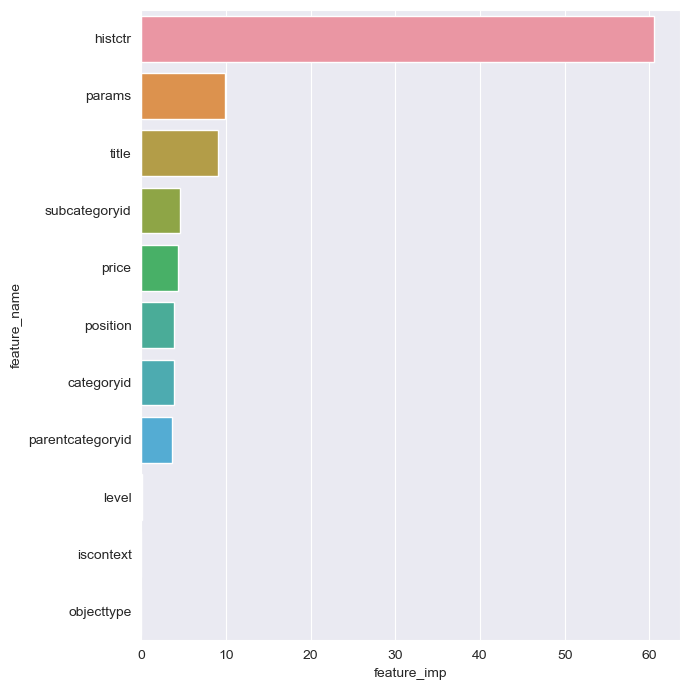

In [18]:
df_base_imp = pd.DataFrame({'feature_name': clf_base.feature_names_, 'feature_imp': clf_base.feature_importances_})
df_base_imp = df_base_imp.sort_values('feature_imp', ascending=False)

plt.figure(figsize=(7, 7))
sns.barplot(x='feature_imp', y='feature_name', data=df_base_imp[:30])
plt.tight_layout()
plt.show()

100%|██████████| 11/11 [31:01<00:00, 169.25s/it]


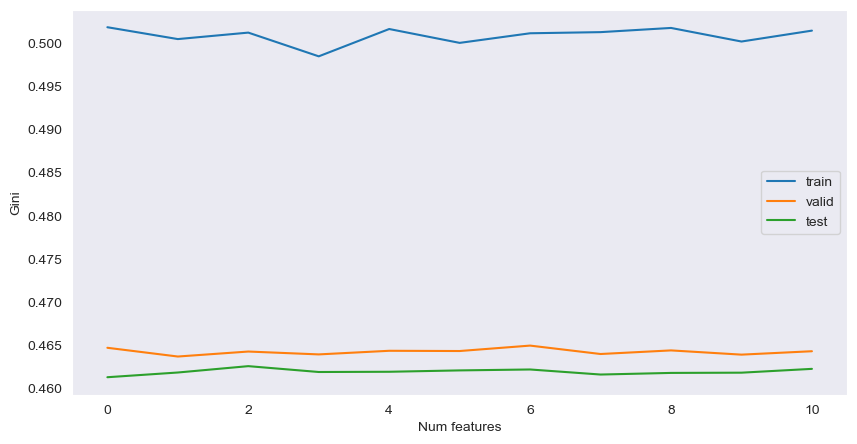

,Train,Valid,Test
0,0.501885,0.464676,0.461259
1,0.500508,0.463661,0.461806
2,0.501259,0.464240,0.462544
3,0.498506,0.463907,0.461865
4,0.501677,0.464327,0.461892
5,0.500067,0.464300,0.462051
6,0.501183,0.464929,0.462157
7,0.501315,0.463953,0.461571
8,0.501801,0.464371,0.461758
9,0.500225,0.463880,0.461786


In [19]:
metric_num_features_dependence(clf_base, X_train, y_train, X_valid, y_valid, X_test, y_test, df_base_imp, to_csv = True)

In [20]:
num_features = 8

final_features = df_base_imp['feature_name'].values[:num_features]
final_features.remove('params')

In [22]:
with open("./final_files/final_features.pickle", 'wb') as f:
    pickle.dump(final_features, f)

In [26]:
with open("./final_files/cat_features.pickle", 'wb') as f:
    pickle.dump(cat_features, f)

In [24]:
X_train.to_csv("./final_files/X_train.csv", index=False)
X_valid.to_csv("./final_files/X_valid.csv", index=False)
X_test.to_csv("C:./final_files/X_test.csv", index=False)

y_train.to_csv("./final_files/y_train.csv", index=False)
y_valid.to_csv("./final_files/y_valid.csv", index=False)
y_test.to_csv("./final_files/y_test.csv", index=False)

# Тюнинг модели

In [1]:
import pandas as pd
import numpy as np
import scipy

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
import optuna

import pickle

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import gc

In [2]:
with open("./final_files/cat_features.pickle", 'rb') as f:
    cat_features = pickle.load(f)
    
cat_features

[]

In [3]:
with open("./final_files/final_features.pickle", 'rb') as f:
    final_features = pickle.load(f)
    
final_features

['histctr',
 'subcategoryid',
 'price',
 'position',
 'categoryid',
 'parentcategoryid']

In [6]:
X_train = pd.read_csv("./final_files/X_train.csv")[final_features]
X_valid = pd.read_csv("./final_files/X_valid.csv")[final_features]
X_test  = pd.read_csv("./final_files/X_test.csv")[final_features]

y_train = pd.read_csv("./final_files/y_train.csv")
y_valid = pd.read_csv("./final_files/y_valid.csv")
y_test  = pd.read_csv("./final_files/y_test.csv")

In [8]:
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1.0),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 20.0),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "task_type": "GPU",
        "cat_features" : cat_features,
        "gpu_ram_part": 0.9,
        "devices": '0',
        "thread_count": -1,
        "use_best_model": True,
        "min_data_in_leaf": 200,
        "bootstrap_type": "Poisson",
        "iterations": 10000,
        "early_stopping_rounds": 50,
        "verbose": False,
        "eval_metric": "AUC",
        "objective": "Logloss",
        "random_seed": 98723
    }
    
    clf = CatBoostClassifier(**params)
    
    clf.fit(X_train, y_train, eval_set = (X_valid, y_valid))
    
    predictions = clf.predict_proba(X_valid)[:, 1]
    
    gini = 2*roc_auc_score(y_valid, predictions)-1
    
    return gini

In [9]:
%%time
study_final = optuna.create_study(study_name="catboost_tuning_base_final", direction="maximize")

study_final.optimize(objective, n_trials = 100, timeout = 6000)

[I 2024-03-26 16:06:52,040] A new study created in memory with name: catboost_tuning_base_final
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:06:55,348] Trial 0 finished with value: 0.1234136134266941 and parameters: {'depth': 4, 'learning_rate': 0.25329169493331744, 'l2_leaf_reg': 10.868888028267015, 'subsample': 0.35599251491123407}. Best is trial 0 with value: 0.1234136134266941.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:06:56,671] Trial 1 finished with value: 0.12341388136090115 and parameters: {'depth': 7, 'learning_rate': 0.7508501871800549, 'l2_leaf_reg': 0.12221883446468658, 'subsample': 0.72328874627273}. Best is trial 1 with value: 0.12341388136090115.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:06:58,013] Trial 2 finished with value: 0.12374132737614318 and parameters: {'depth': 5, 'learning_rate': 0.5488704386114285, 'l2_leaf_reg': 7.5185610129726

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:07:58,751] Trial 25 finished with value: 0.4254770826896861 and parameters: {'depth': 7, 'learning_rate': 0.6232894247172219, 'l2_leaf_reg': 14.80821915874493, 'subsample': 0.7640096097410407}. Best is trial 13 with value: 0.43437642486913486.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:08:00,152] Trial 26 finished with value: 0.1237380459062527 and parameters: {'depth': 8, 'learning_rate': 0.30294202012451116, 'l2_leaf_reg': 16.958165466754267, 'subsample': 0.6839413314657892}. Best is trial 13 with value: 0.43437642486913486.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:08:09,180] Trial 27 finished with value: 0.4344032172036263 and parameters: {'depth': 6, 'learning_rate': 0.1620281084688696, 'l2_leaf_reg': 11.852182991495631, 'subsample': 0.7956990640913315}. Best is trial 27 with value: 0.4344032172036263.
Defau

Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:09:17,388] Trial 50 finished with value: 0.12341340559664693 and parameters: {'depth': 6, 'learning_rate': 0.13782326008729415, 'l2_leaf_reg': 12.760940606677984, 'subsample': 0.48789834446938296}. Best is trial 27 with value: 0.4344032172036263.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:09:21,748] Trial 51 finished with value: 0.43506427461745956 and parameters: {'depth': 8, 'learning_rate': 0.18320156535710722, 'l2_leaf_reg': 11.063826099846182, 'subsample': 0.7719926601834819}. Best is trial 51 with value: 0.43506427461745956.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:09:26,285] Trial 52 finished with value: 0.4334392793585371 and parameters: {'depth': 8, 'learning_rate': 0.1851237650324012, 'l2_leaf_reg': 11.382452427918476, 'subsample': 0.7998626531446146}. Best is trial 51 with value: 0.43506427461745956.


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:11:07,613] Trial 75 finished with value: 0.4310230003420381 and parameters: {'depth': 8, 'learning_rate': 0.37420427562799663, 'l2_leaf_reg': 14.347025548285139, 'subsample': 0.7515527975162297}. Best is trial 51 with value: 0.43506427461745956.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:11:10,733] Trial 76 finished with value: 0.42920209448746305 and parameters: {'depth': 7, 'learning_rate': 0.4203312821607196, 'l2_leaf_reg': 15.405137463989378, 'subsample': 0.782723359641234}. Best is trial 51 with value: 0.43506427461745956.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-03-26 16:11:15,310] Trial 77 finished with value: 0.1234136134266941 and parameters: {'depth': 8, 'learning_rate': 0.19916972489156584, 'l2_leaf_reg': 13.183737281098894, 'subsample': 0.7087700976644365}. Best is trial 51 with value: 0.43506427461745956.
De

CPU times: total: 14min 2s
Wall time: 6min 40s


In [10]:
print('total_trials:', len(study_final.trials))

trial_final = study_final.best_trial
print("best_trial value:", trial_final.value)
print()
print("Params: ")
for key, value in trial_final.params.items():
    print("{} : {}".format(key, value))

total_trials: 100
best_trial value: 0.43532624656431507

Params: 
depth : 7
learning_rate : 0.17510403503017383
l2_leaf_reg : 11.665618726536433
subsample : 0.7705482741285251


In [11]:
best_params_final = trial_final.params
best_params_final

{'depth': 7,
 'learning_rate': 0.17510403503017383,
 'l2_leaf_reg': 11.665618726536433,
 'subsample': 0.7705482741285251}

# Обучение финальной модели на CPU

In [12]:
clf_final = CatBoostClassifier(**best_params_final,
                                 task_type = "CPU",
                                 thread_count = -1,
                                 use_best_model = True,
                                 min_data_in_leaf = 200,
                                 iterations = 10000,
                                 early_stopping_rounds = 50,
                                 verbose = True,
                                 eval_metric = "AUC",
                                 objective = "Logloss",
                                 random_seed = 98723)

clf_final.fit(X_train, y_train, eval_set = (X_valid, y_valid), verbose=100)

0:	test: 0.6401911	best: 0.6401911 (0)	total: 179ms	remaining: 29m 50s
100:	test: 0.7168479	best: 0.7168479 (100)	total: 17.4s	remaining: 28m 22s
200:	test: 0.7173129	best: 0.7173129 (200)	total: 35.4s	remaining: 28m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7173541719
bestIteration = 201

Shrink model to first 202 iterations.


In [14]:
gini_train_final = 2*roc_auc_score(y_train, clf_final.predict_proba(X_train)[:, 1])-1
gini_valid_final = 2*roc_auc_score(y_valid, clf_final.predict_proba(X_valid)[:, 1])-1
gini_test_final = 2*roc_auc_score(y_test, clf_final.predict_proba(X_test)[:, 1])-1

print('gini_train base_model_all_features: ', gini_train_final)
print('gini_valid base_model_all_features: ', gini_valid_final)
print('gini_test base_model_all_features: ', gini_test_final)

print()

print("Относительное изменение Gini base_model_all_features:")
print((gini_train_final - gini_test_final)*100 / gini_train_final)

gini_train base_model_all_features:  0.4658025257141789
gini_valid base_model_all_features:  0.43470834375630596
gini_test base_model_all_features:  0.433464419799501

Относительное изменение Gini base_model_all_features:
6.9424496711554715


In [15]:
with open('./final_files/model.pickle', 'wb') as f:
    pickle.dump(clf_final, f)